In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid", rc={"figure.figsize": (8,5)})

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [2]:
# Load data
CSV_PATH = r"C:\Probook\E\AI\Projects\Data Science\Airbnb Price Prediction\Data\AB_US_2020.csv"  # <- مسیر خودت

use_cols = [
    'id','latitude','longitude','room_type','price','minimum_nights',
    'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365','city'
]
df_raw = pd.read_csv(CSV_PATH, usecols=use_cols)

print(df_raw.head(3))
print("Raw shape:", df_raw.shape)


       id  latitude  longitude        room_type  price  minimum_nights  \
0   38585  35.65146  -82.62792     Private room     60               1   
1   80905  35.59779  -82.55540  Entire home/apt    470               1   
2  108061  35.60670  -82.55563  Entire home/apt     75              30   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                138               1.14                               1   
1                114               1.03                              11   
2                 89               0.81                               2   

   availability_365       city  
0                 0  Asheville  
1               288  Asheville  
2               298  Asheville  
Raw shape: (226030, 11)


In [7]:
# Cleaning
df = df_raw.copy()

# Delete incomplete rows in key columns
df = df.dropna(subset=[
    'price','latitude','longitude','room_type','minimum_nights',
    'number_of_reviews','reviews_per_month','calculated_host_listings_count',
    'availability_365','city'
])

# Remove unrealistic prices and reasonable ranges for columns
df = df[(df['price'] > 10) & (df['price'] < 5000)]
df = df[(df['minimum_nights'] >= 1) & (df['minimum_nights'] <= 365)]
df = df[(df['availability_365'] >= 0) & (df['availability_365'] <= 365)]
df = df[(df['number_of_reviews'] >= 0) & (df['reviews_per_month'] >= 0)]

print("Shape after cleaning:", df.shape)


Shape after cleaning: (177062, 11)


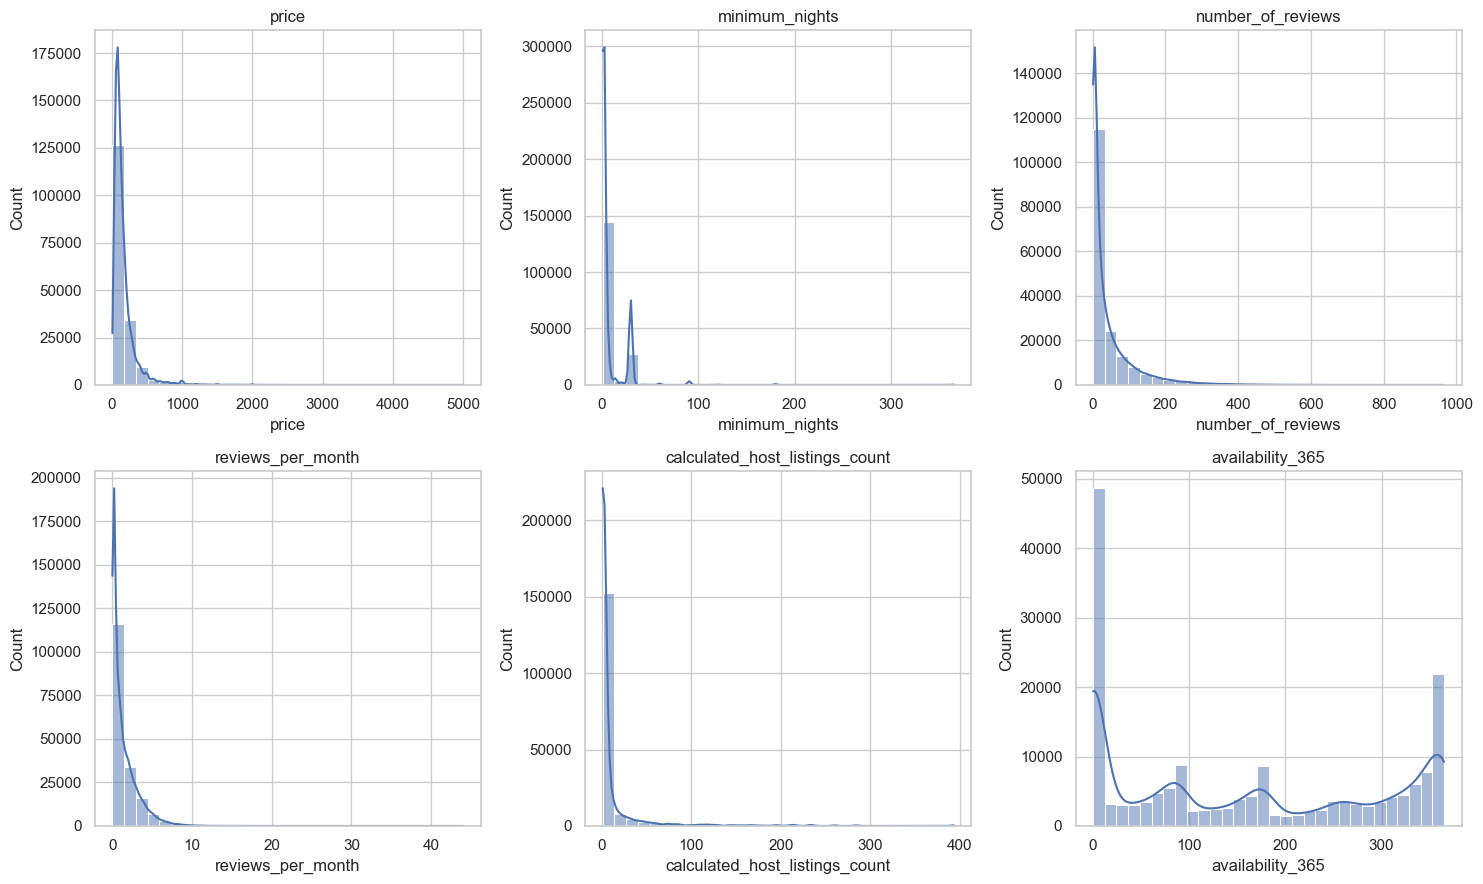

In [8]:
# Quick EDA
numeric_cols = ['price','minimum_nights','number_of_reviews',
                'reviews_per_month','calculated_host_listings_count','availability_365']

fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


In [10]:
# Target transform & city Top-N 
TOP_N = 20
top_cities = df['city'].value_counts().nlargest(TOP_N).index
df['city'] = df['city'].where(df['city'].isin(top_cities), other='Other')

df['price_log'] = np.log1p(df['price'])


In [12]:
# Split
target = 'price_log'
id_col = 'id'

X = df.drop(columns=['price', 'price_log'])
y = df[target]

# First we separate the test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Then we separate validation from train
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.20, random_state=42
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


Train: (113319, 10) Valid: (28330, 10) Test: (35413, 10)


In [13]:
# Preprocess & models
numeric_features = selector(dtype_include=np.number)(X_train)
categorical_features = selector(dtype_include=object)(X_train)

# For linear model: numerical scale + one-hot
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
    ],
    remainder='drop'
)

# For the tree model: numbers unchanged + one-hot
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
    ],
    remainder='drop'
)

pipe_lin = Pipeline(steps=[
    ('prep', preprocessor_linear),
    ('model', LinearRegression())
])

pipe_rf = Pipeline(steps=[
    ('prep', preprocessor_tree),
    ('model', RandomForestRegressor(random_state=42))
])


In [14]:
# CV quick check
cv = KFold(n_splits=5, shuffle=True, random_state=42)

lin_cv = cross_val_score(pipe_lin, X_train, y_train, cv=cv,
                         scoring='neg_root_mean_squared_error')
rf_cv  = cross_val_score(pipe_rf,  X_train, y_train, cv=cv,
                         scoring='neg_root_mean_squared_error')

print("Linear CV RMSE (log):", -lin_cv.mean(), "+/-", lin_cv.std())
print("RF     CV RMSE (log):", -rf_cv.mean(),  "+/-", rf_cv.std())


Linear CV RMSE (log): 0.5975943980198186 +/- 0.0040801004916608576
RF     CV RMSE (log): 0.5050732801429205 +/- 0.0015573127849964662


In [15]:
# Fast GridSearch
cv_fast = KFold(n_splits=3, shuffle=True, random_state=42)

rf_param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [None, 15],
    'model__min_samples_leaf': [1, 5],
    'model__max_features': ['sqrt']
}

rf_search = GridSearchCV(
    estimator=pipe_rf,
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv_fast,
    n_jobs=-1,
    verbose=0
)

rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
print("Best RF CV RMSE (log):", -rf_search.best_score_)

Best RF params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
Best RF CV RMSE (log): 0.5043128657096898


In [16]:
# Validate → select model → retrain on train+valid → test

# Linear on Valid
pipe_lin.fit(X_train, y_train)
y_val_pred_lin_log = pipe_lin.predict(X_valid)
y_val_pred_lin = np.expm1(y_val_pred_lin_log)
y_val_true = np.expm1(y_valid)

lin_val_rmse = rmse(y_val_true, y_val_pred_lin)
lin_val_mae  = mean_absolute_error(y_val_true, y_val_pred_lin)
print(f"Linear Valid → RMSE={lin_val_rmse:.2f}  MAE={lin_val_mae:.2f}")

# Best RF on Valid
best_rf = rf_search.best_estimator_
best_rf.fit(X_train, y_train)
y_val_pred_rf_log = best_rf.predict(X_valid)
y_val_pred_rf = np.expm1(y_val_pred_rf_log)

rf_val_rmse = rmse(y_val_true, y_val_pred_rf)
rf_val_mae  = mean_absolute_error(y_val_true, y_val_pred_rf)
print(f"RF     Valid → RMSE={rf_val_rmse:.2f}  MAE={rf_val_mae:.2f}")

# Better selection and fit on Train+Valid
use_rf = rf_val_rmse <= lin_val_rmse
final_model = best_rf if use_rf else pipe_lin
final_name  = "RandomForest" if use_rf else "LinearRegression"
print("Selected model:", final_name)

# Final fit on train+valid
final_model.fit(X_trainval, y_trainval)

# Evaluation on the test (real)
y_test_pred_log = final_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)
y_test_true = np.expm1(y_test)

print(f"{final_name} Test → RMSE={rmse(y_test_true, y_test_pred):.2f}  MAE={mean_absolute_error(y_test_true, y_test_pred):.2f}")


Linear Valid → RMSE=205.00  MAE=86.62
RF     Valid → RMSE=182.50  MAE=73.01
Selected model: RandomForest
RandomForest Test → RMSE=179.99  MAE=71.67


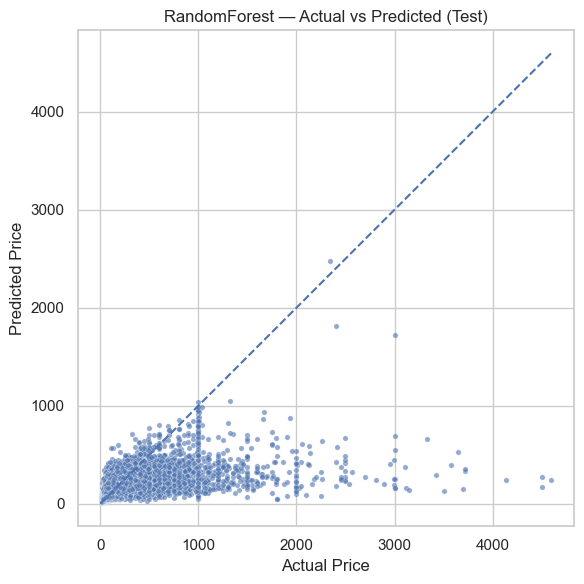

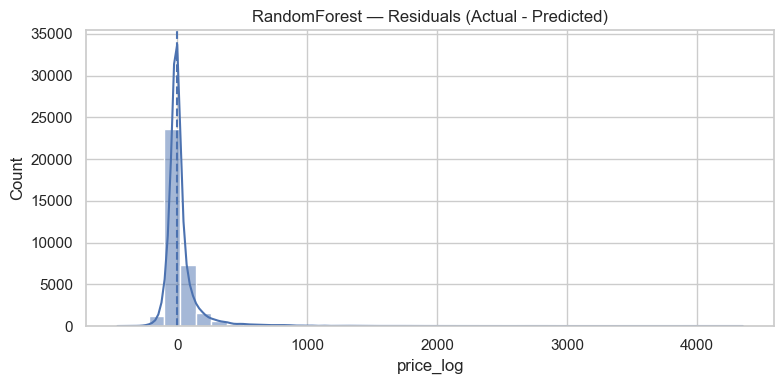

In [17]:
# Diagnostic plots
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_true, y=y_test_pred, s=15, alpha=0.6)
maxv = float(max(y_test_true.max(), y_test_pred.max()))
plt.plot([0, maxv], [0, maxv], linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"{final_name} — Actual vs Predicted (Test)")
plt.tight_layout()
plt.show()

resid = y_test_true - y_test_pred
plt.figure(figsize=(8,4))
sns.histplot(resid, bins=40, kde=True)
plt.axvline(0, linestyle='--')
plt.title(f"{final_name} — Residuals (Actual - Predicted)")
plt.tight_layout()
plt.show()

In [18]:
# Save predictions
out = X_test[[id_col]].copy() if id_col in X_test.columns else pd.DataFrame()
out['ActualPrice'] = y_test_true.values
out['PredictedPrice'] = y_test_pred
out.to_csv("Airbnb_Price_Predictions.csv", index=False)
out.head()

,id,ActualPrice,PredictedPrice
183446,8817106,276.0,260.609800
205253,31395713,85.0,92.920697
125306,7657879,464.0,200.558994
9114,34693490,89.0,178.673702
220777,16456577,503.0,190.986227
